In [ ]:
%pip install pandas numpy librosa scikit-learn seaborn matplotlib tqdm
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns

# Sklearn Modülleri
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer
from sklearn.tree import DecisionTreeClassifier

# Uyarıları kapatmak için (Opsiyonel)
import warnings
warnings.filterwarnings('ignore')

print("Kütüphaneler yüklendi.")

# Görselleştirmelerin düzgün görünmesi için
%matplotlib inline

In [12]:
import pandas as pd
import os

# Metadata'yı oku
metadata = pd.read_csv('UrbanSound8K.csv')
print(metadata.head())

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [13]:
def extract_features(file_name):
    try:
        # Sesi yükle (sampling rate sabitlenmesi önerilir)
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        
        # 1. Zaman Alanı Öznitelikleri
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0)
        rms = np.mean(librosa.feature.rms(y=audio).T, axis=0)
        
        # 2. Frekans Alanı Öznitelikleri
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sample_rate).T, axis=0)
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate).T, axis=0)
        
        # Tüm öznitelikleri birleştir
        features = np.hstack([zcr, rms, mfccs, spectral_centroid, spectral_bandwidth])
        return features
    except Exception as e:
        print(f"Hata oluştu: {file_name}")
        return None

In [ ]:
features_list = []
base_path = 'C:/Users/HP11/OneDrive/Masaüstü/fengineer/archive/'

# Her satır için öznitelikleri çıkar
for index, row in tqdm(metadata.iterrows(), total=len(metadata)):
    file_path = os.path.join(base_path, 'fold' + str(row['fold']), row['slice_file_name'])
    data = extract_features(file_path)
    
    if data is not None:
        features_list.append([data, row['classID']])

# Listeyi DataFrame'e çevir
features_df = pd.DataFrame(features_list, columns=['feature', 'label'])
print("Öznitelik çıkarma tamamlandı!")

In [15]:
# Özellikleri ve etiketleri ayır
X = pd.DataFrame(features_df['feature'].tolist())


feature_names = ['zcr', 'rms'] + [f'mfcc_{i+1}' for i in range(40)] + ['centroid', 'bandwidth']
X.columns = feature_names

y = features_df['label']

# Sonuçları kaydet
X['label'] = y
X.to_csv('X_features.csv', index=False)

In [16]:
# Veriyi yükle (Dosya adını kontrol et)
try:
    df = pd.read_csv("X_features.csv")
    print(f"Veri seti yüklendi. Boyut: {df.shape}")
except FileNotFoundError:
    print("HATA: 'X_features.csv' dosyası bulunamadı. Lütfen dosya yolunu kontrol et.")

# Hedef değişken ve Öznitelikler
# UrbanSound8K'da hedef genellikle 'classID' veya 'label' olarak gelir.
# CSV'de hedef sütunun adı 'classID' veya 'label' ise burayı güncelle:
target_col = 'label'  

if target_col not in df.columns:
    print(f"Uyarı: '{target_col}' sütunu bulunamadı. Sütunlar: {df.columns}")
else:
    X = df.drop(columns=[target_col, 'slice_file_name', 'fold', 'fsID'], errors='ignore') # Gereksiz metadata'yı at
    y = df[target_col]
    
    # Sınıf etiketlerini sayısal hale getir (Eğer string ise)
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    print(f"Öznitelik Sayısı: {X.shape[1]}")
    print(f"Sınıf Sayısı: {len(np.unique(y))}")

Veri seti yüklendi. Boyut: (44, 45)
Öznitelik Sayısı: 44
Sınıf Sayısı: 4


In [17]:
# Stratified Split: Sınıf dengesini koruyarak %80 Eğitim, %20 Test ayırıyoruz
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Ölçeklendirme (Scaling) - MFCC değerleri ile ZCR değerleri aynı aralıkta değil
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns) # Test verisine sadece transform!

print("Eğitim seti boyutu:", X_train_scaled.shape)
print("Test seti boyutu:", X_test_scaled.shape)

Eğitim seti boyutu: (35, 44)
Test seti boyutu: (9, 44)


In [18]:
# Sonuçları saklamak için sözlük
results = {}

# Ortak Değerlendirme Fonksiyonu
def evaluate_model(model, X_data, y_data, method_name):
    # 5-Kat Çapraz Doğrulama
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Metrikler: Accuracy ve F1 (Macro - çoklu sınıf için)
    scoring = {'accuracy': 'accuracy', 'f1_macro': 'f1_macro'}
    
    scores = cross_validate(model, X_data, y_data, cv=cv, scoring=scoring)
    
    mean_acc = scores['test_accuracy'].mean()
    mean_f1 = scores['test_f1_macro'].mean()
    
    print(f"--- {method_name} ---")
    print(f"CV Accuracy: {mean_acc:.4f}")
    print(f"CV F1 Score: {mean_f1:.4f}")
    print("-" * 30)
    
    return mean_acc, mean_f1

# --- BAZ MODEL (Tüm Öznitelikler) ---
base_model = RandomForestClassifier(n_estimators=100, random_state=42)
acc, f1 = evaluate_model(base_model, X_train_scaled, y_train, "Baz Model (Tüm Özellikler)")
results['Baseline'] = {'Accuracy': acc, 'F1': f1, 'Feature Count': X_train.shape[1]}

--- Baz Model (Tüm Özellikler) ---
CV Accuracy: 0.9429
CV F1 Score: 0.8889
------------------------------


In [19]:
# En iyi 20 özelliği seçelim (Sayısı değiştirilebilir)
k_best = 20
selector_filter = SelectKBest(score_func=f_classif, k=k_best)
X_train_filter = selector_filter.fit_transform(X_train_scaled, y_train)

# Hangi özellikler seçildi?
filter_mask = selector_filter.get_support()
selected_filter_features = X.columns[filter_mask]
print(f"Filtre Yöntemi ile Seçilenler: {list(selected_filter_features)}")

# Modeli Eğit ve Test Et
acc, f1 = evaluate_model(base_model, X_train_filter, y_train, "Filtre Yöntemi (ANOVA)")
results['Filter (ANOVA)'] = {'Accuracy': acc, 'F1': f1, 'Feature Count': k_best}

Filtre Yöntemi ile Seçilenler: ['zcr', 'rms', 'mfcc_1', 'mfcc_2', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_10', 'mfcc_12', 'mfcc_13', 'mfcc_16', 'mfcc_17', 'mfcc_20', 'mfcc_23', 'mfcc_30', 'mfcc_35', 'mfcc_36', 'mfcc_37', 'centroid', 'bandwidth']
--- Filtre Yöntemi (ANOVA) ---
CV Accuracy: 0.9429
CV F1 Score: 0.8889
------------------------------


In [20]:
# Önce modeli eğitip önem derecelerini alıyoruz
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_scaled, y_train)

# "SelectFromModel" ortalama önemin üzerindeki özellikleri otomatik seçer
selector_embedded = SelectFromModel(rf_selector, prefit=True)
X_train_embedded = selector_embedded.transform(X_train_scaled)

# Hangi özelliklerin seçildiğini buluyoruz (True/False maskesi)
embedded_mask = selector_embedded.get_support()
selected_embedded_features = X.columns[embedded_mask]

print(f"Gömülü Yöntemle {len(selected_embedded_features)} özellik seçildi.")
print(f"Gömülü Yöntem ile Seçilenler: {list(selected_embedded_features)}")

# Modeli Eğit ve Test Et
acc, f1 = evaluate_model(base_model, X_train_embedded, y_train, "Gömülü Yöntem (RF Importance)")
results['Embedded (RF)'] = {'Accuracy': acc, 'F1': f1, 'Feature Count': selected_embedded_features}

Gömülü Yöntemle 17 özellik seçildi.
Gömülü Yöntem ile Seçilenler: ['zcr', 'rms', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_10', 'mfcc_12', 'mfcc_13', 'mfcc_16', 'mfcc_20', 'mfcc_30', 'mfcc_37', 'mfcc_39', 'centroid', 'bandwidth']
--- Gömülü Yöntem (RF Importance) ---
CV Accuracy: 0.9429
CV F1 Score: 0.8889
------------------------------


In [21]:
# --- 3. SARMALAMA YÖNTEMİ (RFE - Recursive Feature Elimination) ---

# GÜNCELLEME: Tutarlılık için burada da RandomForest kullanıyoruz.
# Hızlanması için 'n_jobs=-1' (tüm işlemcileri kullan) ekledik.
# Ağaç sayısını (n_estimators) 50 yaptık ki işlem çok uzun sürmesin.
rfe_estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)

# Her adımda 1 özellik eleyerek en iyi 15 özelliği bul
rfe_selector = RFE(estimator=rfe_estimator, n_features_to_select=15, step=1)

print("RFE işlemi başlıyor (Bu biraz zaman alabilir)...")
rfe_selector.fit(X_train_scaled, y_train)

# Seçilen özellikleri dönüştür
X_train_rfe = rfe_selector.transform(X_train_scaled)

# Hangi özellikler seçildi?
rfe_mask = rfe_selector.get_support()
selected_rfe_features = X.columns[rfe_mask]
print(f"RFE ile Seçilen 15 Özellik: {list(selected_rfe_features)}")

# Modeli Eğit ve Test Et (Değerlendirme yine 100 ağaçlı ana modelle yapılır)
acc, f1 = evaluate_model(base_model, X_train_rfe, y_train, "Sarmalama Yöntemi (RFE - RF Tabanlı)")
results['Wrapper (RFE)'] = {'Accuracy': acc, 'F1': f1, 'Feature Count': 15}

RFE işlemi başlıyor (Bu biraz zaman alabilir)...
RFE ile Seçilen 15 Özellik: ['zcr', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_10', 'mfcc_12', 'mfcc_13', 'mfcc_16', 'mfcc_20', 'mfcc_27', 'mfcc_32', 'mfcc_36', 'mfcc_37']
--- Sarmalama Yöntemi (RFE - RF Tabanlı) ---
CV Accuracy: 0.9429
CV F1 Score: 0.8889
------------------------------


                Accuracy        F1  \
Baseline        0.942857  0.888889   
Filter (ANOVA)  0.942857  0.888889   
Embedded (RF)   0.942857  0.888889   
Wrapper (RFE)   0.942857  0.888889   

                                                    Feature Count  
Baseline                                                     44.0  
Filter (ANOVA)                                               20.0  
Embedded (RF)   Index(['zcr', 'rms', 'mfcc_2', 'mfcc_3', 'mfcc...  
Wrapper (RFE)                                                15.0  


<Figure size 1000x600 with 0 Axes>

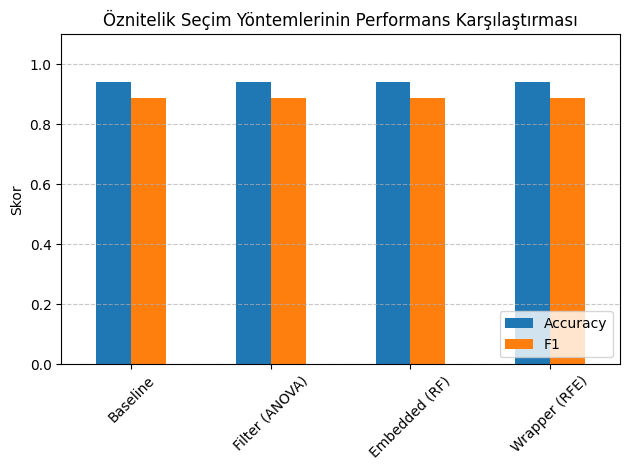

In [22]:
# Sonuçları DataFrame'e çevir
df_results = pd.DataFrame(results).T
print(df_results)

# Grafik Çizimi
plt.figure(figsize=(10, 6))
df_results[['Accuracy', 'F1']].plot(kind='bar', ylim=(0.0, 1.1))
plt.title('Öznitelik Seçim Yöntemlerinin Performans Karşılaştırması')
plt.ylabel('Skor')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()